In [1]:
from __future__ import absolute_import, division, print_function

from IPython.display import display as display
from IPython.display import Markdown as markdown
import random as rd
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time as t


#Measurement Computing mcculw imports
from mcculw import ul
from mcculw.enums import (FunctionType, ScanOptions, ULRange, InterfaceType)
from ctypes import cast, POINTER, c_double, c_ushort, c_ulong
from mcculw.ul import ULError
from mcculw.enums import InterfaceType
from mcculw.enums import ULRange
from mcculw.enums import AnalogInputMode


# USB-201 demonstation class
class daq:


    @classmethod 
    def __init__(self, device_name = "USB-201", rate = 100, samples=100):
        self.board_name = device_name
        self.points_per_channel = samples
        self.sample_rate = rate
        self.num_chans = 4
        self.max_length = 2000
        self.total_count = 1
        self.board_number = -1
        self.memhandle = 0
        self.temp = np.zeros((1,4))
        self.arr = np.zeros((self.max_length, self.num_chans))
        self.device = 0
        self.open_device(self)

        
    @classmethod 
    def __del__(self):
        self.close_device(self)

    def __str__(self):
        return f"{self.board_name}"

    def _create_array(self):
        np.resize(self.arr, (self.points_per_channel, self.num_chans))
        self.arr.fill(0)
        return self.arr


    def set_sample_rate(self, sample_rate=100):
        if int(sample_rate * self.num_chans) > 100000:
            display(markdown(f"Sample rate too high, the maximum is 25,000 Hz. Reset to 100 Hz"))
            self.sample_rate = 100
        else:
            self.sample_rate = sample_rate
            display(markdown(f"Sample rate changed to {self.sample_rate} Hz"))
        return self.sample_rate



    def set_samples_per_channel(self, number_of_samples=333):
        if int(number_of_samples) > self.max_length:
            display(markdown(f"Requested samples per channel {number_of_samples} is greater than {self.max_length}, reset to 1000"))
            self.points_per_channel = 1000
        else:
            self.points_per_channel = number_of_samples
            display(markdown(f"Samples per channel changed to {self.points_per_channel}"))
        return self.points_per_channel

    '''
    open_device is executed in __init___

    It attempts to find a device by its commercial name. Once found, 
    it sets the board number, sample rate and number of sameples
    per channel
    '''

    def open_device(self):

        board_num = -1
        board_index = 0
        board_num = -1

        ul.ignore_instacal()

        dev_list = ul.get_daq_device_inventory(InterfaceType.USB)
        if len(dev_list) > 0:
            for device in dev_list:
                if str(device) == self.board_name:
                    self.device = device
                    display(markdown(f"Found {device} board number = {board_index}"))
                    display(markdown(f"Serial number: {device.unique_id}"))
                    display(markdown(f"Product type: {hex(device.product_id)}"))
                    display(markdown(f"Samples per channel {self.points_per_channel} "))
                    display(markdown(f"Sample rate is {self.sample_rate} "))
                    self.board_num = board_index
                    ul.create_daq_device(self.board_num, device)
                    return
            if board_num == -1:
                display(markdown(f"Device {self.board_name} not found"))
                
        else:
            display(markdown("No devices detected"))



    '''
    This function is call by the destructor:
    def __del__(self):
        self.close_device(self)
    It closes the device and frees the allocated buffer memory
    '''

    def close_device(self):
        if self.memhandle:
            # Free the buffer in a finally block to prevent a memory leak.
            ul.win_buf_free(self.memhandle)
        if self.board_num > -1:
            ul.release_daq_device(self.board_num)
            display(markdown(f"{self.board_name} closed..."))
        

    '''
    plotting routine, requires a 2D array containing four channels
    '''

    def plot_data(self, arr):

        x = np.linspace(start=0, stop=19, num=self.points_per_channel, dtype=np.dtype(np.int16))

        ch0 = [row[0] for row in arr]
        ch1 = [row[1] for row in arr]
        ch2 = [row[2] for row in arr]
        ch3 = [row[3] for row in arr]

        plt.plot(ch0, 'b', ch1, 'r', ch2, 'g', ch3, 'k')
        plt.xlabel('Samples');
        plt.ylabel('Volts');
        plt.title('Plotting Demonstration')
        plt.legend(['Channel 0', 'Channel 1', 'Channel 2', 'Channel 3'])
        plt.grid()
        plt.show()

    '''
    get_data() 

    Determines the total sample count,
    which is samples per channel times the 
    number of channels. 

    For simplicity, the channels are hard coded to 
    be 0 - 3

    The default buffer is resize to me the user demands

    mcculw a_in_scan function is used to grab requested
    scans. FOREGROUND scan mode is used,
    which blocks the function until all the samples have
    been acquired.     
    '''

    def get_data(self):

        memhandle = None

        low_chan = 0
        high_chan = 3

        self.total_count = self.points_per_channel * self.num_chans
        self.arr = np.resize(self.arr, (self.points_per_channel, self.num_chans))
        self.memhandle = ul.scaled_win_buf_alloc(self.total_count)
    
        ctypes_array = cast(self.memhandle, POINTER(c_double))

        # Check if the buffer was successfully allocated
        if not self.memhandle:
            raise Exception('Error: Failed to allocate memory')

        # Start the scan
        e = ul.a_in_scan(self.board_num, low_chan, high_chan, self.total_count,
                         self.sample_rate, ULRange.BIP10VOLTS, self.memhandle,
                         ScanOptions.FOREGROUND | ScanOptions.SCALEDATA)

        display(markdown("Scan completed successfully."))

        data_index = 0
        for row in range(self.points_per_channel):
            self.temp = self.arr[row]
            for chan in range(self.num_chans):
                eng_value = ctypes_array[data_index]
                self.temp[chan] = eng_value
                data_index += 1

        return self.arr


# Welcome to my USB-201 Demonstration

Found USB-201 board number = 0

Serial number: 1FFC8D1

Product type: 0x113

Samples per channel 200 

Sample rate is 1000 

Samples per channel changed to 2000

Sample rate changed to 2000 Hz

Scan completed successfully.

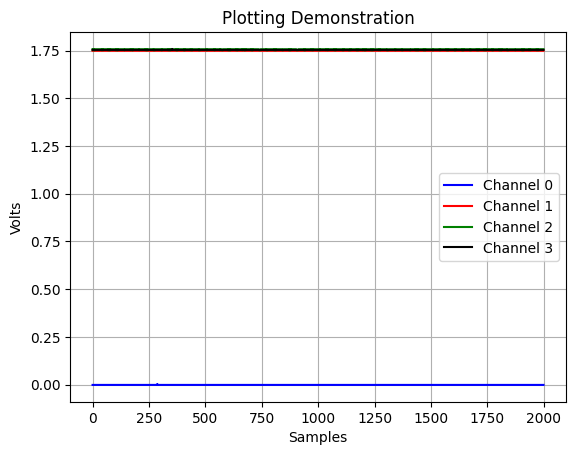

,Ch0,Ch1,Ch2,Ch3
0,-0.001978,1.74919,1.757415,1.753897
1,-0.001978,1.74919,1.757415,1.753897
2,-0.001978,1.74919,1.752309,1.753897
3,-0.001978,1.74919,1.757415,1.753897
4,-0.001978,1.74919,1.757415,1.753897
...,...,...,...,...
1995,-0.001978,1.74919,1.757415,1.753897
1996,-0.001978,1.74919,1.757415,1.753897
1997,-0.001978,1.74919,1.757415,1.753897
1998,-0.001978,1.74919,1.757415,1.753897


USB-201 closed...

In [2]:
display(markdown("# Welcome to my USB-201 Demonstration"))

mcc = daq("USB-201", rate=1000, samples=200)


new_number_of_samples = mcc.set_samples_per_channel(number_of_samples=2000)
new_rate = mcc.set_sample_rate(sample_rate = 2000)

daq_data = mcc.get_data()
mcc.plot_data(daq_data)


h=display(display_id=2)
df = pd.DataFrame(data=daq_data[0:mcc.points_per_channel], columns=['Ch0','Ch1', 'Ch2','Ch3'])
h.update(df)

del mcc
